# Linear scaling

This notebook applies a linear scaling approach to correct the bias of seasonal forecasts, in this case the ECMWF SEAS5 precipitation, temperature and evaporation ensembles. This approach consists of correcting the monthly mean values so they match the control values (observations).

## Inputs

- obsr   = observed data [rain, temp, evap] - array [h,3]
- ctrl   = control or reference data
- tdates = daily dates. Suitable formats:
    - [dd,mm,yyyy] - array [h,3]
    - date - array [h,1]
    - day since 01/01/1900 - array [h,1]
    
## Outputs


## 1. Import general libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from Submodules.Climatology_data import Climatology_data

months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%M')

## 2. Initial options

In [2]:
provider = 'ECMWF' # seasonal forecast provider
year     = 2014   # year
month    = 11     # month
day      = 1       # day

## 3. Load data and define bias correction
### 3.1 Forecast data

In [3]:
from netCDF4 import Dataset
folder_path = provider+' files'
data_fore = Dataset(folder_path+"//"+str(year)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")
dates_fore = pd.to_datetime(data_fore['time'][:]-24, unit='h',origin = pd.Timestamp('01-01-1900'))
# the next day at 00:00 we need to substract one day (-24h) to reflect that the first data member corresponds to the first 
# day and not to the next day at 00:00

# Temperature
T_fore=data_fore.variables['t2m'][:] # in degK
T_fore_ens = T_fore.mean(3).mean(2)-273.15 # in degC

# Evaporation
E_fore=data_fore.variables['e'][:]*1000
E_fore_cum = -E_fore.mean(3).mean(2)  # in mm 
E_fore_ens = np.zeros(np.shape(E_fore_cum))
for i in np.arange(len(E_fore_cum[0,:])):
    for j in np.arange(len(E_fore_cum[:,0])-1):
        E_fore_ens[j+1,i] = np.maximum(E_fore_cum[j+1,i]-E_fore_cum[j,i],0)
        
# Precipitation
P_fore=data_fore.variables['tp'][:]*1000
P_fore_cum = P_fore.mean(3).mean(2)  # in mm 
P_fore_ens = np.zeros(np.shape(P_fore_cum))
for i in np.arange(len(P_fore_cum[0,:])):
    for j in np.arange(len(P_fore_cum[:,0])-1):
        P_fore_ens[j+1,i] = np.maximum(P_fore_cum[j+1,i]-P_fore_cum[j,i],0)

# number of months covered by the forecast
if month>dates_fore[-1].month:
    num_months = dates_fore[-1].month - month + 1 + 12
else:
    num_months = dates_fore[-1].month - month + 1

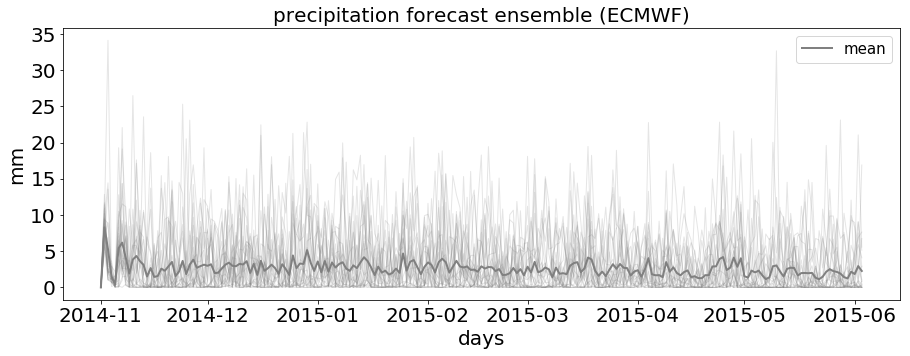

In [20]:
fig1,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(dates_fore,P_fore_ens,'grey',alpha=0.2,linewidth=1)
ax1.plot(dates_fore,np.mean(P_fore_ens,axis=1),'grey',alpha=1,linewidth=2, label = 'mean')
ax1.set_xlabel('days', fontsize = 20)
ax1.set_ylabel('mm', fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
ax1.set_title('precipitation forecast ensemble (ECMWF)', fontsize = 20)
ax1.legend(fontsize = 15)
plt.show()

### 3.2 Observed data 

In [21]:
data_obsr = 'Historical data//ClimdataWim.csv'

dates_obsr = pd.to_datetime(np.genfromtxt(data_obsr, delimiter = ',',skip_header=1,usecols=0,dtype='str'), format = '%d/%m/%Y')
weather_data_obsr = np.genfromtxt(data_obsr, delimiter = ',',skip_header=1)
PET = weather_data_obsr[0:,1]
Rain = weather_data_obsr[0:,2]
Temp = weather_data_obsr[0:,3]

ydays = np.zeros(len(dates_fore))
for i in range(len(dates_fore)):
    ydays[i] = int(dates_fore[i].timetuple().tm_yday)

P_clim = np.zeros((len(ydays),len(np.arange(1981,year))))
count = 0
for y in np.arange(1981,year):
    for i in range(len(ydays)):
        ID_clim = np.where((dates_obsr.year==y) & (dates_obsr.dayofyear==int(ydays[i])))[0]
        P_clim[i,count] = Rain[ID_clim]
    count += 1
P_clim[0,:] = 0

outputs_clim = Climatology_data(28.8,'daily',1981,2016)

Rain_obs_mat = outputs_clim[0]
I_obs_mat = outputs_clim[1]

# Historical weekly rain and inflow ensembles (from 1968 till year of study -1)
Rain_clim_ens = np.zeros([len(ydays),np.shape(Rain_obs_mat[:,Rain_obs_mat[0,:]<year])[1]])
I_clim_ens = np.zeros([len(ydays),np.shape(I_obs_mat[:,I_obs_mat[0,:]<year])[1]])
for i in range(len(ydays)):
    Rain_clim_ens[i,:] = Rain_obs_mat[int(ydays[i]),Rain_obs_mat[0,:]<year]
    I_clim_ens[i,:] = I_obs_mat[int(ydays[i]),I_obs_mat[0,:]<year]
    
Rain_clim_ens[0,:] = 0
I_clim_ens[0,:] = 0

### 3.3 Load control data (ECMWF seasonal hindcasts) and forecast bias correction

In [22]:
num_mem = 25

T_fore_corr= np.zeros(np.shape(T_fore_ens))
E_fore_corr= np.zeros(np.shape(E_fore_ens))
P_fore_corr= np.zeros(np.shape(P_fore_ens))

for i in np.arange(0,num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    T_ctrl_all = []
    E_ctrl_all = []
    P_ctrl_all = []

    # Observed data
    ID_obsr = np.where((dates_obsr.year>=1981) & (dates_obsr.year<year) & (dates_obsr.month==m))[0]

    T_obsr = Temp[ID_obsr]

    E_obsr = PET[ID_obsr]
    
    P_obsr = Rain[ID_obsr]
    P_obsr[0]=0

    for y in np.arange(1981,year):

        #Control/reference data
        data_ctrl = Dataset(folder_path+"//"+str(y)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")

        dates_ctrl = pd.to_datetime(data_ctrl['time'][:]-24, unit='h',origin = pd.Timestamp('1900-01-01'))
        # the data is given every 24 h, so the it always starts the next day at 00:00 we need to substract 
        # one day (-24h) to reflect that the first data member corresponds to the first day and not to the next day at 00:00

        ID_ctrl = np.where((dates_ctrl.year>=1981) & (dates_ctrl.month==m))[0]

        # Temperature
        T_ctrl=data_ctrl.variables['t2m'][:] # in degK
        T_ctrl_ens = T_ctrl.mean(3).mean(2).mean(1)-273.15 # in degC

        T_ctrl_all = np.append(T_ctrl_all,np.reshape(T_ctrl_ens[ID_ctrl],[np.size(T_ctrl_ens[ID_ctrl]),1]))
        
        # Evaporation
        E_ctrl=data_ctrl.variables['e'][:]*1000
        E_ctrl_cum = -E_ctrl.mean(3).mean(2).mean(1)  # in mm 
        E_ctrl_ens = np.zeros(np.shape(E_ctrl_cum))
        for j in np.arange(len(E_ctrl_cum[:])-1):
            E_ctrl_ens[j+1] = np.maximum(E_ctrl_cum[j+1]-E_ctrl_cum[j],0)
        E_ctrl_all = np.append(E_ctrl_all,np.reshape(E_ctrl_ens[ID_ctrl],[np.size(E_ctrl_ens[ID_ctrl]),1]))

        # Precipitation
        P_ctrl=data_ctrl.variables['tp'][:]*1000
        P_ctrl_cum = P_ctrl.mean(3).mean(2).mean(1) # in mm 
        P_ctrl_ens = np.zeros(np.shape(P_ctrl_cum))
        for j in np.arange(len(P_ctrl_cum[:])-1):
            P_ctrl_ens[j+1] = np.maximum(P_ctrl_cum[j+1]-P_ctrl_cum[j],0)
        P_ctrl_all = np.append(P_ctrl_all,np.reshape(P_ctrl_ens[ID_ctrl],[np.size(P_ctrl_ens[ID_ctrl]),1]))

    # Define the forecast data each month
    ID_scen = np.where((dates_fore.year>=1981) & (dates_fore.month==m))[0]
    T_scen = T_fore_ens[ID_scen]
    E_scen = E_fore_ens[ID_scen]
    P_scen = P_fore_ens[ID_scen]

    T_scen_corr = T_scen*np.mean(T_obsr)/np.mean(T_ctrl_all)
    T_fore_corr[ID_scen] = T_scen_corr

    E_scen_corr = E_scen*np.mean(E_obsr)/np.mean(E_ctrl_all)
    E_fore_corr[ID_scen] = E_scen_corr

    P_scen_corr = P_scen*np.mean(P_obsr)/np.mean(P_ctrl_all)
    P_fore_corr[ID_scen] = P_scen_corr

In [23]:
T_hind_all = np.zeros((len(dates_fore),len(np.arange(1981,year))))
E_hind_all = np.zeros((len(dates_fore),len(np.arange(1981,year))))
P_hind_all = np.zeros((len(dates_fore),len(np.arange(1981,year))))
count = 0
for y in np.arange(1981,year):
    data_hind = Dataset(folder_path+"//"+str(y)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")
    # Temperature
    T_hind_ens=data_hind.variables['t2m'][:] # in degK
    T_hind_all[:,count] = T_hind_ens.mean(3).mean(2).mean(1)-273.15 # in degC
    # Evaporation
    E_hind_ens=data_hind.variables['e'][:]*1000
    E_hind_cum = -E_hind_ens.mean(3).mean(2).mean(1)  # in mm 
    for j in np.arange(len(E_hind_cum[:])-1):
        E_hind_all[j+1,count] = np.maximum(E_hind_cum[j+1]-E_hind_cum[j],0)
    # Precipitation
    P_hind_ens=data_hind.variables['tp'][:]*1000
    P_hind_cum = P_hind_ens.mean(3).mean(2).mean(1) # in mm 
    for j in np.arange(len(P_hind_cum[:])-1):
        P_hind_all[j+1,count] = np.maximum(P_hind_cum[j+1]-P_hind_cum[j],0)
    count += 1

## 4. Plot results
### 4.1 Temperature

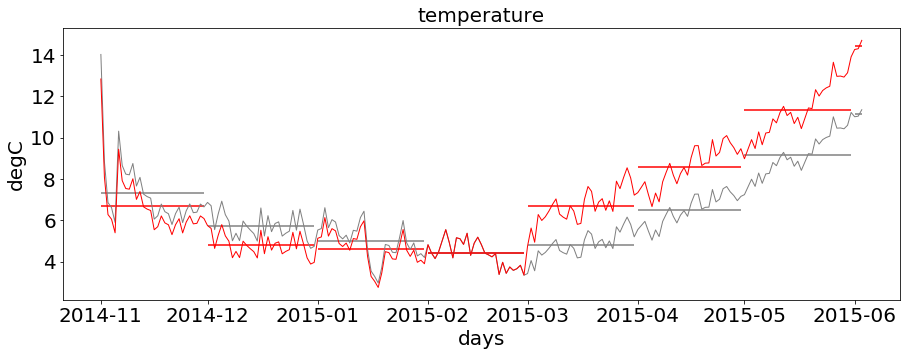

In [25]:
fig,ax0 = plt.subplots(figsize=(15, 5))
#ax0.plot(dates_fore,T_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax0.plot(dates_fore,T_fore_corr,'red',alpha=0.1,linewidth=1)
#ax0.plot(dates_fore,T_ctrl_ens,'blue',alpha=1,linewidth=2)
ax0.plot(dates_fore,np.mean(T_fore_ens,axis=1),'grey',alpha=1,linewidth=1)
ax0.plot(dates_fore,np.mean(T_fore_corr,axis=1),'red',alpha=1,linewidth=1)
ax0.set_xlabel('days', fontsize = 20)
ax0.set_ylabel('degC', fontsize = 20)
for label in (ax0.get_xticklabels() + ax0.get_yticklabels()):
    label.set_fontsize(20)
T_fore_month_mean = np.zeros(num_months)
T_fore_corr_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    T_fore_month_mean [i] = np.mean(T_fore_ens[ID_month])
    T_fore_corr_month_mean [i] = np.mean(T_fore_corr[ID_month])
    ax0.hlines(T_fore_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax0.hlines(T_fore_corr_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='red')
ax0.set_title('temperature', fontsize = 20)
#ax0.set_xlim([1,30])
plt.show()

### 4.2 Evaporation

<function matplotlib.pyplot.show(*args, **kw)>

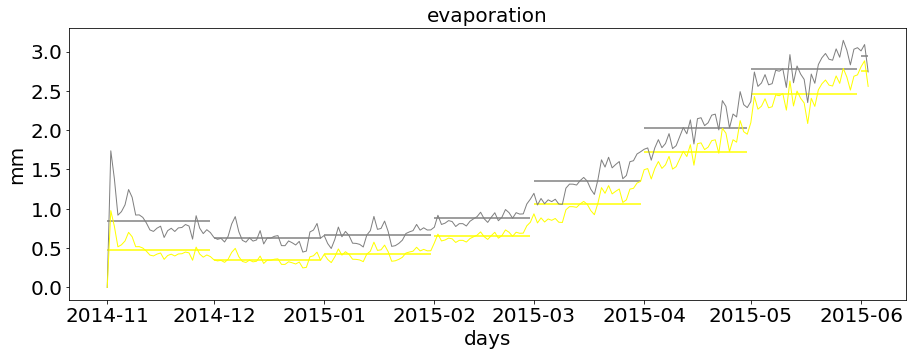

In [27]:
fig,ax1 = plt.subplots(figsize=(15, 5))
#ax1.plot(dates_fore,E_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax1.plot(dates_fore,E_fore_corr,'yellow',alpha=0.1,linewidth=1)
ax1.plot(dates_fore,np.mean(E_fore_ens,axis=1),'grey',alpha=1,linewidth=1)
ax1.plot(dates_fore,np.mean(E_fore_corr,axis=1),'yellow',alpha=1,linewidth=1)
ax1.set_xlabel('days', fontsize = 20)
ax1.set_ylabel('mm', fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
E_fore_month_mean = np.zeros(num_months)
E_fore_corr_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    E_fore_month_mean [i] = np.mean(E_fore_ens[ID_month])
    E_fore_corr_month_mean [i] = np.mean(E_fore_corr[ID_month])
    ax1.hlines(E_fore_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax1.hlines(E_fore_corr_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='yellow',alpha=1)
ax1.set_title('evaporation', fontsize = 20)
plt.show()

### 4.3 Precipitation

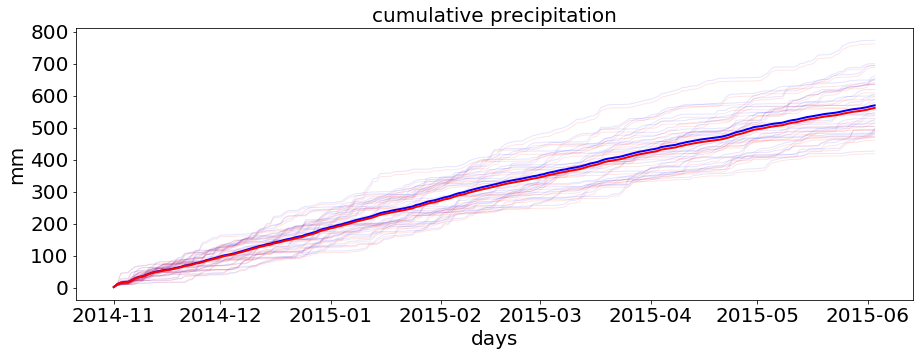

In [36]:
fig,ax2 = plt.subplots(figsize=(15, 5))
#ax2.plot(dates_fore,np.mean(P_fore_ens,axis=1),'grey',alpha=1,linewidth=2)
ax2.plot(dates_fore,P_fore.mean(2)[:,:,0],'blue',alpha=0.1,linewidth=1)
ax2.plot(dates_fore,np.mean(P_fore.mean(2)[:,:,0],axis=1),'blue',alpha=1,linewidth=2)
ax2.plot(dates_fore,P_fore.mean(2)[:,:,1],'red',alpha=0.1,linewidth=1)
ax2.plot(dates_fore,np.mean(P_fore.mean(2)[:,:,1],axis=1),'red',alpha=1,linewidth=2)
ax2.set_xlabel('days', fontsize = 20)
ax2.set_ylabel('mm', fontsize = 20)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
ax2.set_title('cumulative precipitation', fontsize = 20)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

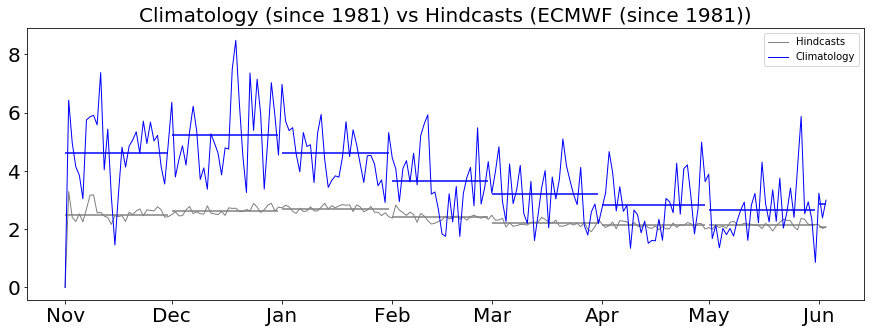

In [11]:
fig,ax2 = plt.subplots(figsize=(15, 5))
#ax2.plot(dates_fore,P_hind_all,'grey',alpha=0.3,linewidth=1)
#ax2.plot(dates_fore,Rain_clim_ens,'blue',alpha=0.3,linewidth=1)
ax2.plot(dates_fore,np.mean(P_hind_all,axis=1),'grey',alpha=1,linewidth=1,label='Hindcasts')
ax2.plot(dates_fore,np.mean(P_clim,axis=1),'blue',alpha=1,linewidth=1,label='Climatology')
# format the ticks
myFmt = mdates.DateFormatter("%b")
ax2.xaxis.set_major_formatter(myFmt)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
P_hind_month_mean = np.zeros(num_months)
P_clim_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    P_hind_month_mean [i] = np.mean(P_hind_all[ID_month])
    P_clim_month_mean [i] = np.mean(P_clim[ID_month])
    ax2.hlines(P_hind_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax2.hlines(P_clim_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='blue',alpha=1)
ax2.set_title('Climatology (since 1981) vs Hindcasts (ECMWF (since 1981))', fontsize = 20)
ax2.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

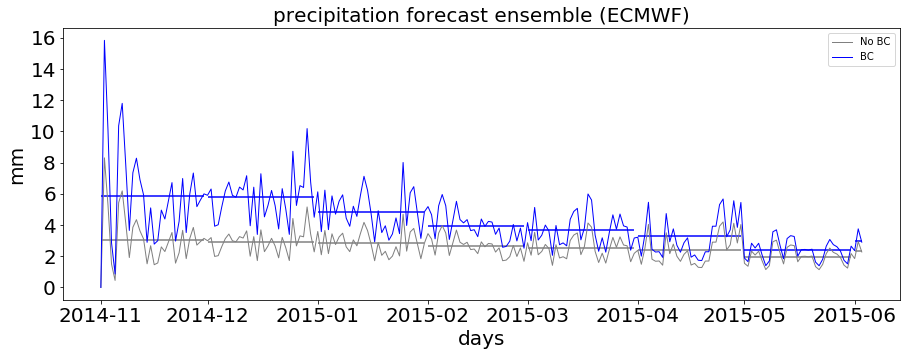

In [12]:
fig,ax2 = plt.subplots(figsize=(15, 5))
#ax2.plot(dates_fore,P_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax2.plot(dates_fore,P_fore_corr,'blue',alpha=0.1,linewidth=1)
#ax2.axhline(np.mean(np.mean(P_fore_ens[0:31,:])),color='grey')
ax2.plot(dates_fore,np.mean(P_fore_ens,axis=1),'grey',alpha=1,linewidth=1,label='No BC')
#ax2.axhline(np.mean(np.mean(P_fore_corr[0:31,:])),color='blue')
ax2.plot(dates_fore,np.mean(P_fore_corr,axis=1),'blue',alpha=1,linewidth=1,label = 'BC')
ax2.set_xlabel('days', fontsize = 20)
ax2.set_ylabel('mm', fontsize = 20)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
P_fore_month_mean = np.zeros(num_months)
P_fore_corr_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    P_fore_month_mean [i] = np.mean(P_fore_ens[ID_month])
    P_fore_corr_month_mean [i] = np.mean(P_fore_corr[ID_month])
    ax2.hlines(P_fore_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax2.hlines(P_fore_corr_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='blue',alpha=1)
ax2.set_title('precipitation forecast ensemble (ECMWF)', fontsize = 20)
#ax2.set_xlim([dates_fore[0],dates_fore[31]])
ax2.legend()
plt.show

## 5. Save bias corrected data to a file (.npy)

In [ ]:
data_fore_bc = np.zeros([np.shape(T_fore_corr)[0],np.shape(T_fore_corr)[1],4])*np.nan
data_fore_bc[:,0,0] = data_fore['time'][:]-24
data_fore_bc[:,:,1] = T_fore_corr
data_fore_bc[:,:,2] = E_fore_corr
data_fore_bc[:,:,3] = P_fore_corr
#os.mkdir(provider+'//Bias corrected - LS')
#np.save(provider+"//Bias corrected - LS//"+str(year)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain",data_fore_bc)